# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find the optimal location to open an arcade in Manhattan. Our client has been to almost much all the arcades in Manhattan, but he does not find any of them satisfactory. Being an 80s kid, he lived through the golden age of arcades, and he wants to open one that will satisfy his nostalgia, and show the kids how it really used to be.

The target audience will mostly be early teenagers to young adults. We would need to find the neighborhoods in Manhattan where the density of this crowd is high. It would make sense to search for areas which have a **high number of universities or schools and a low number of arcades**.

## Data <a name="data"></a>

Based on this business problem, we can identify that we need data such as:
* locations of existing arcades
* locations of schools, universities and colleges
* geographical data like the coordinates and areas of each neighborhood in Manhattan

To get the locations of arcades and the academic institutions, we will use the [Foursquare API](https://developer.foursquare.com/docs/). We will use the categoryids provided in the Foursquare [website](https://developer.foursquare.com/docs/build-with-foursquare/categories/) to search for the data of Arcades and College & Universities. We will retrieve the Name, Latitude, Longitude and Category of these locations.

To get the neighborhood boudaries, we will use the geojson file from this [github repository](https://github.com/blackmad/neighborhoods/blob/master/manhattan.geojson). Furthermore, we will use the [geopy.geocoders](https://geopy.readthedocs.io/) module for the coordinates of the neighborhoods. 

**Import the necessary libraries**

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import requests
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from PIL import Image

**Create a Nominatim instance to get the geohraphical coordinates of Manhattan**

In [5]:
geolocator = Nominatim(user_agent='city_explorer')
location = geolocator.geocode('Manhattan, NY')
latitude = location.latitude
longitude = location.longitude
print(f'The geographical coordinates of Manhattan are {latitude}, {longitude}')

The geographical coordinates of Manhattan are 40.7896239, -73.9598939


**Use the FourSquare API to get the necessary data**
We are interested in venues in the 'arcade' category. From the [Foursquare website](https://developer.foursquare.com/docs/build-with-foursquare/categories/), we can see that the categoryId for arcades is '4bf58dd8d48988d1e1931735'.

Foursquare credentials are in the hidden cell below.

In [10]:
#foursquare credentials hidden

In [9]:
url = 'https://api.foursquare.com/v2/venues/search'
#CategoryId of Arcades. Taken from https://developer.foursquare.com/docs/build-with-foursquare/categories/
categoryid = '4bf58dd8d48988d1e1931735'

params = dict(
client_id=CLIENTID,
client_secret=CLIENTSECRET,
v='20180323',
ll='{},{}'.format(latitude,longitude),
categoryId=categoryid,
limit=100
)
data = requests.get(url=url, params=params).json()
data['response'].keys()

dict_keys(['venues', 'confident'])

In [11]:
requests.get(url=url, params=params).url

'https://api.foursquare.com/v2/venues/search?client_id=T10NG1UBRQCPQ0DFAHQCSLH30TUEH5YQXX2XEG51LXKXLR2Z&client_secret=WXWWRBQTNNFZ4LXWBQRZEDEGMYMWJEQSVDCULUZX4WRMTF1R&v=20180323&ll=40.7896239%2C-73.9598939&categoryId=4bf58dd8d48988d1e1931735&limit=100'

In [12]:
data.keys()

dict_keys(['meta', 'response'])

In [13]:
items = data['response']['venues']
# items

**From the data received from Foursquare, get only the necesassry columns. Convert this to a dataframe**

In [14]:
venues = [(v['name'],v['location']['lat'],v['location']['lng'],\
              v['categories'][0]['name']) for v in items]
venues = pd.DataFrame(venues)
venues.columns = ['Name','Latitude','Longitude','Category']
venues.head()

Name   Latitude  Longitude  Category
0           The Shelter Uptown  40.825184 -73.942968    Arcade
1                      Barcade  40.712061 -73.951239       Bar
2  7B Horseshoe Bar aka Vazacs  40.725014 -73.981330  Dive Bar
3                      Barcade  40.744417 -73.994423       Bar
4                  The Zarcade  40.694607 -73.907475    Arcade

**Plot the venue categories. We can see that we have categories that are not 'Arcade'** 

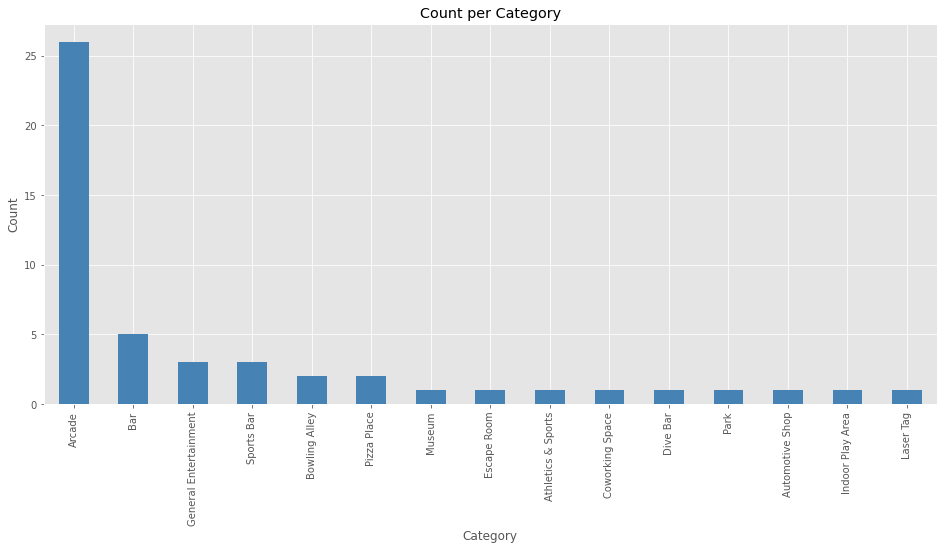

In [15]:
mpl.style.use('ggplot')
plt.figure(figsize=(16,7))
venues['Category'].value_counts().plot(kind='bar',color='steelblue')
# plt.yticks(range(0,10))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count per Category')
plt.show()

**Filter out the categories that are not 'Arcade'**

In [248]:
venues = venues[venues['Category'] == 'Arcade']

**Create a folium map to plot the Arcades in and near Manhattan**

In [16]:
arcademap = folium.Map(location=[latitude,longitude],zoom_start=12)

colorarray = list(map(mpl.colors.rgb2hex,(mpl.cm.rainbow(np.linspace(0,1,len(venues['Category'].unique()))))))
colordf = pd.DataFrame(colorarray,index=venues['Category'].unique())

for lat,lng,name,cat in zip(venues['Latitude'],venues['Longitude'],venues['Name'],venues['Category']):
    label = folium.Popup('{}, {}'.format(name,cat),parse_html=True)
    folium.Marker(
        [lat,lng],
        popup=label,
        icon=folium.features.CustomIcon('arcadeicon.png',icon_size=(30,25)),
        parse_html=False
    ).add_to(arcademap)

arcademap.save('arcademap.html')


arcademap

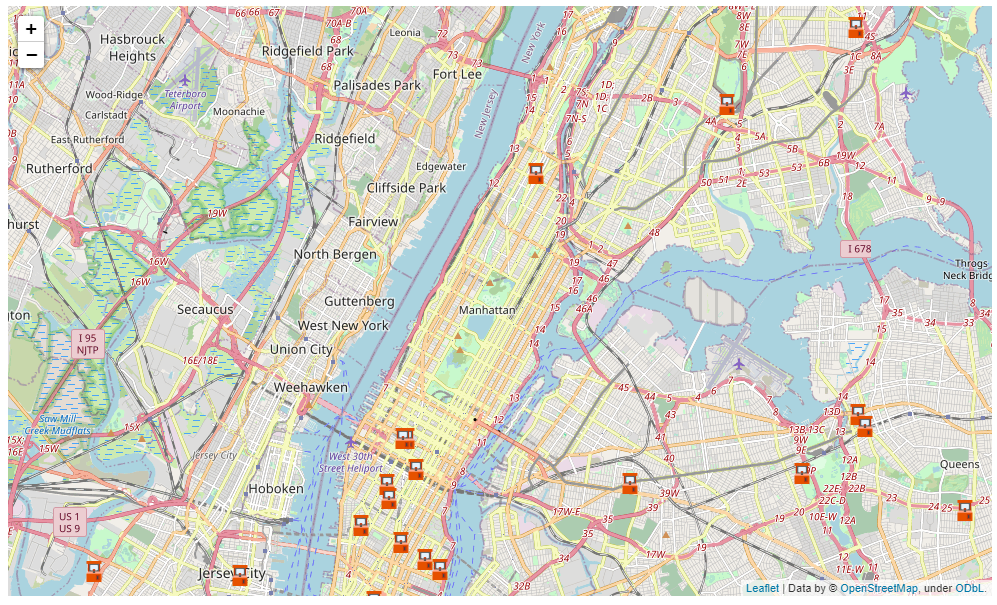

In [30]:
#display the created map as an image so that users on github can see the output
im = Image.open('arcade_snip.PNG')
im

**Mark the neighborhoods in Manhattan using a geojson file**

In [17]:
# geojson file from https://github.com/blackmad/neighborhoods/blob/master/manhattan.geojson
import sys
import geojson
with open('manhattan.geojson') as f:
    gj = geojson.load(f)
features = gj['features']

In [18]:
man_neigh_map = folium.Map(location=[latitude,longitude],zoom_start=12)
neighborhood_list = []
for feat in features:
    neighborhood_list.append(feat['properties']['name'])
    folium.GeoJson(feat,
                   style_function = (lambda x : {'color':'gray'})
                   ).add_to(man_neigh_map)
man_neigh_map

**Get the geographical coordinates of the neighborhood locations using geocoder and mark them in the map**

In [20]:
dfneighborhoods = []
for neigh in neighborhood_list:
    cell = {}
    n_loc = geolocator.geocode('{}, Manhattan, New York, NY'.format(neigh))
    cell['Neighborhood'] = neigh
    cell['Latitude'] = n_loc.latitude
    cell['Longitude'] = n_loc.longitude
    dfneighborhoods.append(cell)
dfneighborhoods = pd.DataFrame(dfneighborhoods)
dfneighborhoods.head()

Neighborhood   Latitude  Longitude
0  Battery Park City  40.711017 -74.016937
1       Central Park  40.782773 -73.965363
2            Chelsea  40.746491 -74.001528
3          Chinatown  40.716491 -73.996250
4       Civic Center  40.713679 -74.002404

In [22]:
for lat,lon,neigh in zip(dfneighborhoods['Latitude'],dfneighborhoods['Longitude'],dfneighborhoods['Neighborhood']):
    folium.Marker(
        [lat,lon],
        popup=folium.Popup(neigh,parse_html=False)        
    ).add_to(man_neigh_map)
    
man_neigh_map.save('man_neigh_map.html')
man_neigh_map

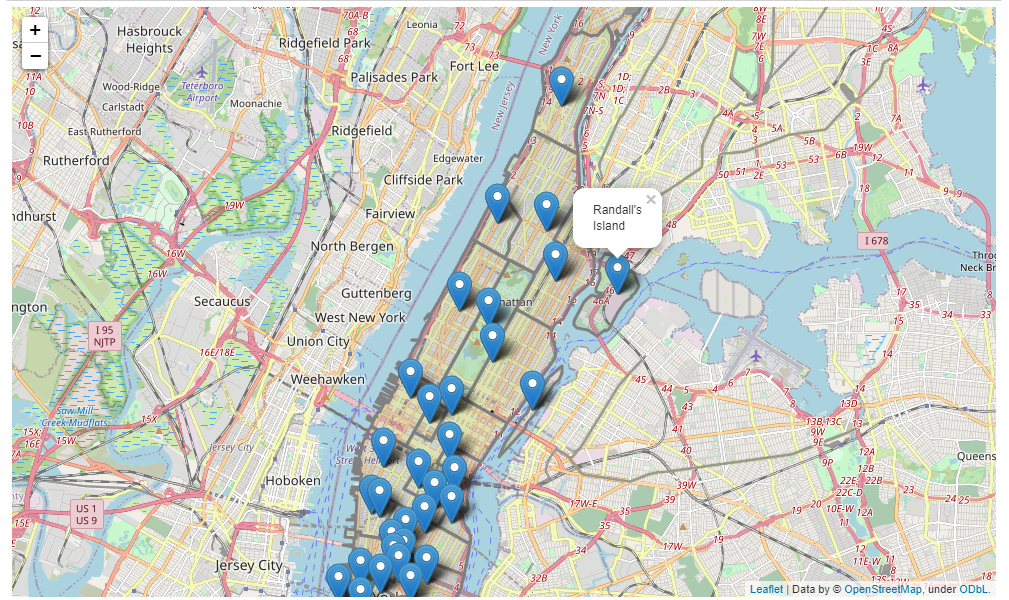

In [272]:
#display the created map as an image so that users on github can see the output
im = Image.open('neighborhood_snip.PNG')
im

**Let's now get the locations of universities/colleges in the Manhattan area using the Foursquare API**

In [49]:
#CategoryId of Universities/Colleges/Schools. Taken from https://developer.foursquare.com/docs/build-with-foursquare/categories/
categoryid = '4d4b7105d754a06372d81259'

uni_params = dict(
client_id=CLIENTID,
client_secret=CLIENTSECRET,
v='20180323',
ll='{},{}'.format(latitude,longitude),
categoryId=uni_categoryid,
limit=100
)
uni_data = requests.get(url=url, params=uni_params).json()
uni_data['response'].keys()

dict_keys(['venues', 'confident'])

**Put the data in a dataframe**

In [69]:
uni = [(u['name'],u['location']['lat'],u['location']['lng'],\
              u['categories'][0]['name']) for u in uni_data['response']['venues']]
uni = pd.DataFrame(uni)
uni.columns = ['Name','Latitude','Longitude','Category']
uni

Name   Latitude  Longitude  \
0             Icahn School of Medicine at Mount Sinai  40.788249 -73.953110   
1   New York Presbyterian Hospital Weill Cornell M...  40.764802 -73.954055   
2                                   MetroTech Commons  40.694088 -73.985710   
3                 Academy of Our Lady of Good Counsel  41.039467 -73.763842   
4                          Rutgers University @ UMDNJ  40.740558 -74.191446   
5                      Fairleigh Dickinson University  40.896735 -74.032889   
6                               Zadie's Nurturing Den  40.714488 -74.354733   
7                          NYU Langone Medical Center  40.741822 -73.974185   
8               Teachers College, Columbia University  40.809912 -73.960776   
9                    P.S. 100 The Coney Island School  40.577567 -73.970844   
10                       Rutherford Montessori School  40.829204 -74.112270   
11                    Queensborough Community College  40.754929 -73.756671   
12                              St. John's University  40.722970 -73.794246   
13                    Mount Vernon Board Of Education  40.916118 -73.824420   
14             Rutgers Biomedical and Health Sciences  40.740299 -74.189537   
15                 Columbia University Medical Center  40.842288 -73.943481   
16                 Columbia-Jerome Greene Science Ctr  40.817072 -73.958074   
17                              Seton Hall University  40.741969 -74.249127   
18                     Kingsborough Community College  40.578401 -73.936186   
19                          New Jersey Medical School  40.740348 -74.189252   
20                         Montclair State University  40.862707 -74.199076   
21                                               YMCA  40.542453 -74.163043   
22                                University Hospital  40.740185 -74.190695   
23  International Affairs Building - Columbia Univ...  40.807394 -73.959773   
24                               JHS 50 John D. Wells  40.711689 -73.959953   
25                    Fashion Institute of Technology  40.747175 -73.994983   
26                                Columbia University  40.807191 -73.963061   
27                       New School University Center  40.735506 -73.993784   
28                                       Cornell Tech  40.755223 -73.957107   
29                           Columbia Business School  40.808725 -73.961520   
30                                      Mercy College  41.021938 -73.873830   
31                    Stevens Institute of Technology  40.744899 -74.025402   
32                       The City College of New York  40.820504 -73.948548   
33                Fordham University - Lincoln Center  40.770279 -73.984452   
34                                   Brooklyn College  40.631922 -73.951220   
35                         The Rockefeller University  40.762847 -73.956277   
36                                 NYU Midtown Campus  40.753916 -73.981996   
37                                    University Hall  40.862705 -74.199109   
38                   Belfer Medical Research Building  40.765284 -73.956156   
39               John Jay College of Criminal Justice  40.770390 -73.988337   
40      Borough of Manhattan Community College (BMCC)  40.718283 -74.011785   
41                               Medgar Evers College  40.666500 -73.957241   
42                     Fordham University - Rose Hill  40.861041 -73.885490   
43                   Fordham University School of Law  40.771507 -73.985200   
44                                    Pace University  40.710720 -74.005743   
45                          SUNY College of Optometry  40.754086 -73.982675   
46          Columbia University School of Social Work  40.810262 -73.958330   
47                                  St. Ephrem School  40.625458 -74.015097   
48                                    Pratt Institute  40.691410 -73.963051   
49                                     SUNY Downstate  40.655101 -73.944475   

                   

In [70]:
#Check for any unnecessary categories
cat = uni['Category'].value_counts()
cat.to_frame()

Category
University                          23
Medical School                       6
College Academic Building            5
Hospital                             3
Community College                    3
General College & University         3
Student Center                       1
Law School                           1
High School                          1
College Science Building             1
Gym                                  1
College Quad                         1
Elementary School                    1

**Filter out everything that does not have 'School' or 'University' or 'College' as the category**

In [71]:
uni = uni[uni['Category'].str.contains('university',case=False) | uni['Category'].str.contains('school',case=False) \
   | uni['Category'].str.contains('college',case=False)]

**Plot the universities/colleges/schools in the map**

In [56]:
for lat,lng,name,cat in zip(uni['Latitude'],uni['Longitude'],uni['Name'],uni['Category']):
    label = folium.Popup('{}, {}'.format(name,cat),parse_html=True)
    folium.Marker(
        [lat,lng],
        popup=label,
        icon=folium.features.CustomIcon('uni_icon.png',icon_size=(17,15)),
        parse_html=False
    ).add_to(arcademap)


arcademap.save('unimap.html')

arcademap

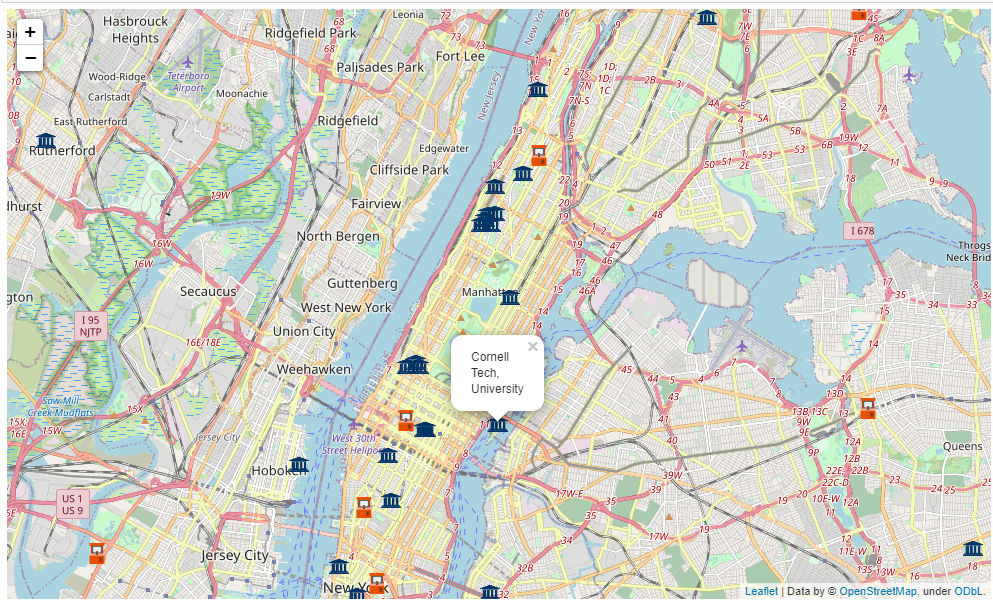

In [273]:
#display the created map as an image so that users on github can see the output
im = Image.open('uni_snip.PNG')
im

Now we have all the universities and arcades in Manhattan. We are now ready to use this data analysis to create the right model that will find the optimal spot to open a new arcade 

## Methodology <a name="methodology"></a>

We will now use the location data to find the location with the highest density of Universities. To find this cluster, we will use the **DBSCAN** (Density Based Spatial Clustering of Applications with Noise).

Using recursion, we will use the optimal value of epsilon and choose the min_samples to be = 5. Finally, we will plot the different clusters in different colors and identify the cluster with the highest density. If the number of arcades near this cluster is low, we will find the optimal spot to be near that area. 

**Normalize the location data**

In [72]:
from sklearn.preprocessing import StandardScaler

In [73]:
#Normalize the location data
X = StandardScaler().fit_transform(uni[['Latitude','Longitude']])

**Import DBSCAN and cluster the universities based on density**

In [74]:
from sklearn.cluster import DBSCAN

In [75]:
db = DBSCAN(eps=0.2,min_samples=5)
db.fit(X)
db.labels_

array([-1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,
       -1,  0, -1,  1,  0, -1, -1,  0, -1, -1,  0,  1, -1, -1,  1, -1, -1,
        1, -1, -1, -1,  1, -1,  1,  0, -1, -1, -1], dtype=int64)

**Append the labels to the uni dataframe**

In [76]:
uni.insert(0,'Cluster',db.labels_)
uni['Cluster'] = uni['Cluster'].map(lambda x: x+1)
uni.head()

<ipython-input-76-2d2aeefb0c31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni['Cluster'] = uni['Cluster'].map(lambda x: x+1)


Cluster                                     Name   Latitude  Longitude  \
0        0  Icahn School of Medicine at Mount Sinai  40.788249 -73.953110   
2        0                        MetroTech Commons  40.694088 -73.985710   
3        0      Academy of Our Lady of Good Counsel  41.039467 -73.763842   
4        0               Rutgers University @ UMDNJ  40.740558 -74.191446   
5        0           Fairleigh Dickinson University  40.896735 -74.032889   

         Category  
0  Medical School  
2    College Quad  
3     High School  
4      University  
5      University

**Plot the clusters in the folium Map**

In [62]:
unimapclust = folium.Map(location=[latitude,longitude],zoom_start=12)

colorarray = list(map(mpl.colors.rgb2hex,(mpl.cm.Dark2_r(np.linspace(0,1,len(uni['Cluster'].unique()))))))
colordf = pd.DataFrame(colorarray,index=uni['Cluster'].unique())

for feat in features:
    neighborhood_list.append(feat['properties']['name'])
    folium.GeoJson(feat,
                   style_function = (lambda x : {'color':'gray'})
                   ).add_to(unimapclust)

for lat,lng,name,clust in zip(uni['Latitude'],uni['Longitude'],uni['Name'],uni['Cluster']):
    if 1 == 1:# and cat == 'Coffee Shop':
        label = folium.Popup('{}, Cluster {}'.format(name,clust),parse_html=True)
        folium.CircleMarker(
            [lat,lng],
            radius=5,
            popup=label,
            color=colordf.loc[clust, 0],
            fill_color=colordf.loc[clust, 0],
            fill_opacity=0.7,
            parse_html=False
        ).add_to(unimapclust)
       

unimapclust.save('unimapclust.html')


unimapclust

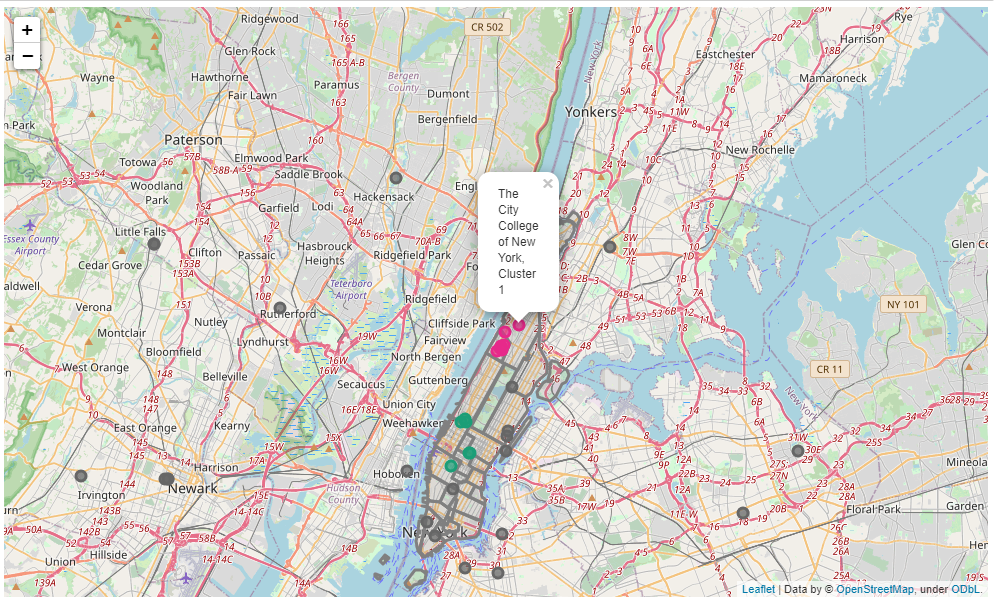

In [275]:
#display the created map as an image so that users on github can see the ouput
im = Image.open('uni_mapclust.PNG')
im

## Analysis <a name="analysis"></a>

We can see above that the cluster in pink seems to be the densest cluster. We will perform further analysis by visualization.

**Let's add the existing arcades to the above map and mark the spot that seems to be to open an arcade**

In [78]:
finalmap = unimapclust

fin_loc = geolocator.geocode('Bloomingdale, New York, NY')

for lat,lng,name,cat in zip(venues['Latitude'],venues['Longitude'],venues['Name'],venues['Category']):
    label = folium.Popup('{}, {}'.format(name,cat),parse_html=True)
    folium.Marker(
        [lat,lng],
        popup=label,
        icon=folium.features.CustomIcon('arcadeicon.png',icon_size=(30,25)),
        parse_html=False
    ).add_to(finalmap)

folium.Circle(
#     location=[fin_loc.latitude,fin_loc.longitude],
    [40.797479,-73.970044],
    color='#499abf',
    radius=1000,
    fill=True,
    opacity=0.6,
    fill_opacity=0.5,
    
).add_to(finalmap)    

finalmap.save('finalmap.html')

finalmap

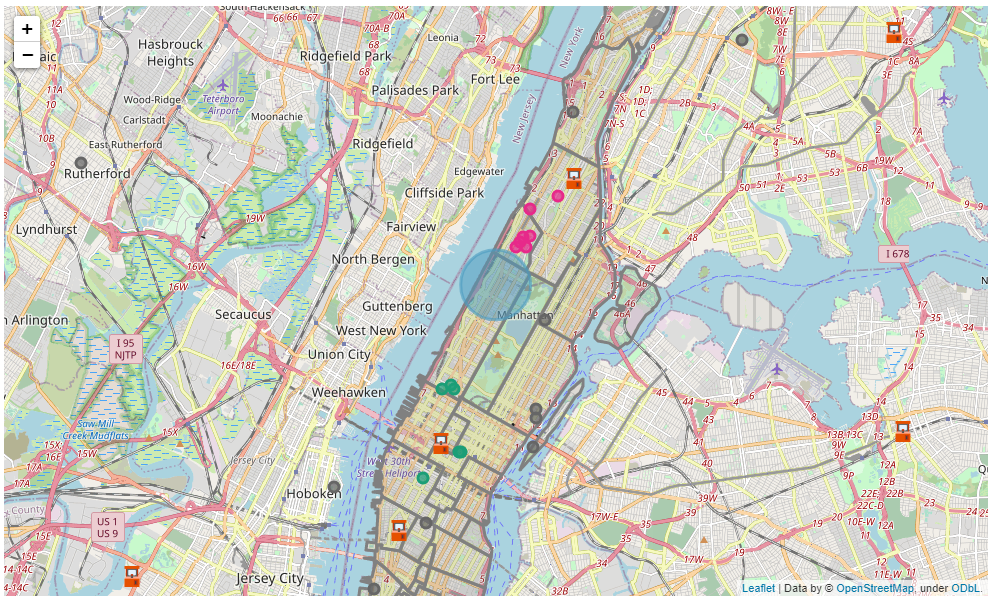

In [276]:
#display the created map as an image so that users on github can see the ouput
im = Image.open('finalmap_snip.PNG')
im

## Results and Discussion <a name="results"></a>

During the visualization of the data, we found that the northern part of Manhattan had only one arcade. When we plotted the data, we also saw that the density of Universities in the northern part (neighborhoods of Morningside Heights and Harlem) is quite high. This already looks quite promising.

After running a simple DBSCAN on the university locations, we found that indeed, the highest density was to the north of Central Park (colored in green), and the second densest cluster was in the south of Central Park (colored in green). Furthermore, the northern part has fewer arcades than the southern part of the borough. 

## Conclusion <a name="conclusion"></a>

Using the visualizations, analysis and the results of our clustering model, we can conclude that the ideal location to open an arcade would be just to the south of Morningside Heights. We have found this spot to be in the neighborhood of Upper West Side, in Bloomingdale. The area is marked by a blue circle in the final visualization. We can expect the students of Columbia University to start using this arcade when it is open.